# Projeto Final Machine Learning

Neste projeto iremos utilizar modelos de machine learning para prever preços de Airbnb nos Estados Unidos. Para isso iremos começar importanto as bibliotecas necessárias e os dados.

In [ ]:
import os
import json
import requests
import re
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=11y5YttDreRfx-jHjOoT1rxs6HW6HKPqU'

# Read the CSV file directly into a DataFrame
Airbnb = pd.read_csv(url, low_memory=False)

Podemos conhecer melhor os dados utilizando os comandos

In [ ]:
Airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226030 entries, 0 to 226029
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              226030 non-null  int64  
 1   name                            226002 non-null  object 
 2   host_id                         226030 non-null  int64  
 3   host_name                       225997 non-null  object 
 4   neighbourhood_group             110185 non-null  object 
 5   neighbourhood                   226030 non-null  object 
 6   latitude                        226030 non-null  float64
 7   longitude                       226030 non-null  float64
 8   room_type                       226030 non-null  object 
 9   price                           226030 non-null  int64  
 10  minimum_nights                  226030 non-null  int64  
 11  number_of_reviews               226030 non-null  int64  
 12  last_review     

In [ ]:
seed = 42
np.random.seed(seed)
Airbnb.sample(n = 5, random_state = seed)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
182851,6123863,"Stylish Remodeled House with Deck, Steps to Di...",9072515,Jessica,NaN,West University Heights,32.75992,-117.14292,Entire home/apt,215,2,28,12/07/20,0.44,1,300,San Diego
46603,33341740,"Lux420, Rftop deck, Hot tub, Elvtr in ‚ù§Ô∏è o...",111000374,Elma,NaN,Five Points,39.75436,-104.98469,Entire home/apt,599,30,35,29/12/19,2.42,3,362,Denver
18675,21784725,LARGE POOL HOUSE IN HOLLYWOOD NEW POOL DECK,158736535,Euseb,NaN,Hollywood,26.01600,-80.23088,Entire home/apt,214,2,10,17/02/20,0.36,1,331,Broward County
90901,30562982,"Modern 2 BR House in Hollywood, Keyless Entry!",134940933,Jonathan,City of Los Angeles,Hollywood Hills,34.11915,-118.32028,Entire home/apt,290,30,0,NaN,NaN,1,0,Los Angeles
25085,41833198,New Renovated House - Hard Rock / Hollywood Beach,120149672,Yaseen,NaN,Hollywood,26.01587,-80.23007,Entire home/apt,250,2,10,28/04/20,2.16,1,15,Broward County


As features são as seguintes:

1. ID: Um valor numérico para o Airbnb;
2. Name: Nome do  Airbnb;
3. host_id: Id para o dono do Airbnb;
4. host_name: Nome do dono do Airbnb;
5. neighbourhood_group:  Grupo no qual a vizinhança(região) se enquadra;
6. neighbourhood: Nome da vizinhança(região);
7. latitude: Latitude de listagem do Aribnb;
8. longitude: Longitude de listagem do Aribnb;  
9. room_type: Tipo de quarto oferecido;
10. price: Preço da estadia por noite;
11. minimum_nights: Minímo de noites que precisa ficar hospedado;
12. number_of_reviews: Número de reviews do Airbnb;
13. last_review: Data do último review feito para o Airbnb;
14. reviews_per_month: Número de reviews que o Airbnb recebe por mês;
15. calculated_host_listings_count:
16. availability_365: Disponibilidade durante o ano;
17. city: Cidade em que o Airbnb é localizado;   

Podemos observar melhor as variaveis numéricas fazendo histogramas, e utilizando o comando .describe()

In [ ]:
Airbnb.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,1.808240e+05,1.808240e+05,180824.000000,180824.000000,180824.000000,180824.000000,180824.000000,141899.000000,180824.000000,180824.000000
mean,2.545662e+07,9.344431e+07,35.647098,-103.264143,219.189582,10.149770,34.491146,1.431253,16.700250,159.262321
std,1.316837e+07,9.813054e+07,6.861322,26.252838,561.791921,25.427055,63.579611,1.684629,51.154448,140.249691
min,1.090000e+02,2.300000e+01,18.920990,-159.714900,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,1.517355e+07,1.400621e+07,32.759950,-118.605797,75.000000,1.000000,1.000000,0.230000,1.000000,0.000000
50%,2.587195e+07,5.143385e+07,37.246970,-97.828420,121.000000,2.000000,8.000000,0.810000,2.000000,140.000000
75%,3.770920e+07,1.496012e+08,40.723833,-76.926752,200.000000,7.000000,39.000000,2.060000,6.000000,311.000000
max,4.556085e+07,3.679176e+08,47.734620,-70.995950,24999.000000,1250.000000,966.000000,44.060000,593.000000,365.000000


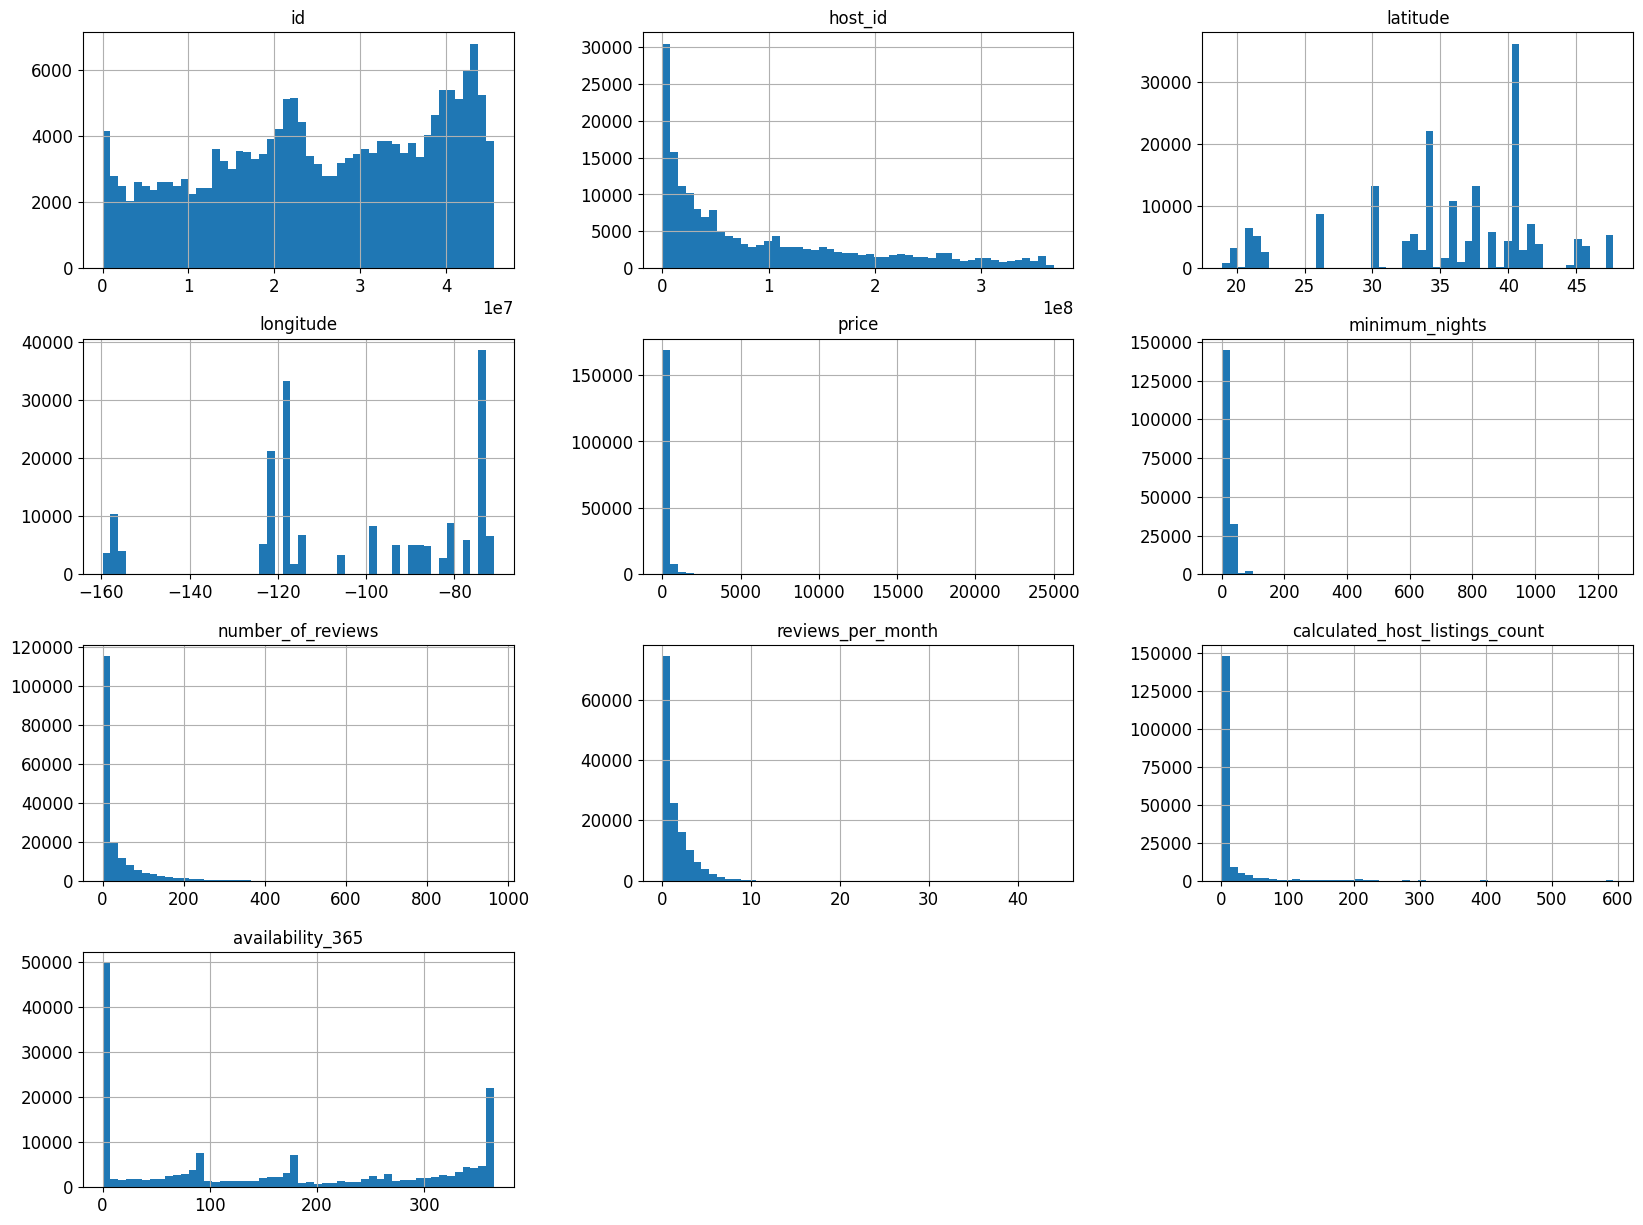

In [ ]:
Airbnb.hist(bins=50, figsize=(20,15))
plt.show()

# Separando o Conjunto de Dados

Agora faremos a separação dos dados para o treinamento dos modelos. Mas essa separação será estratificada da seguinte forma

In [ ]:
Airbnb["price_strat"] = pd.cut(Airbnb["price"],
                               bins=[-1, 60, 125, 300, 25000],
                               labels=[1, 2, 3, 4])

#Airbnb["minimum_nights_strat"] = Airbnb["minimum_nights_strat"].fillna(Airbnb["minimum_nights_strat"].mode()[0])
Airbnb["price_strat"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 226030 entries, 0 to 226029
Series name: price_strat
Non-Null Count   Dtype   
--------------   -----   
226030 non-null  category
dtypes: category(1)
memory usage: 221.1 KB


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, test_index in split.split(Airbnb, Airbnb["price_strat"]):
    Airbnb_train_data = Airbnb.loc[train_index]
    test_set = Airbnb.loc[test_index]

Para ver se fizemos uma boa estratificação podemos comparar com uma amostra aleátoria

In [ ]:
def income_cat_proportions(data):
    return data["price_strat"].value_counts() / len(data)

In [ ]:
fake_train_set, fake_test_set = train_test_split(Airbnb, test_size=0.2, random_state=seed)

In [ ]:
compare_props = pd.DataFrame({
    "Geral": income_cat_proportions(Airbnb),
    "Estratificado": income_cat_proportions(test_set),
    "Aleatorio": income_cat_proportions(fake_test_set),
}).sort_index()

compare_props["Aleatório %erro"] = 100 * compare_props["Aleatorio"] / compare_props["Geral"] - 100
compare_props["Estratificado %erro"] = 100 * compare_props["Estratificado"] / compare_props["Geral"] - 100

compare_props

,Geral,Estratificado,Aleatorio,Aleatório %erro,Estratificado %erro
price_strat,,,,,
1,0.170570,0.170575,0.169845,-0.425377,0.002594
2,0.351263,0.351259,0.351325,0.017633,-0.001260
3,0.342990,0.342985,0.343848,0.250239,-0.001290
4,0.135177,0.135181,0.134982,-0.144007,0.003273


Disso podemos observar uma %erro menor com a amostra estratifica. Com isso podemos agora retirar a coluna minimum_nights_strat e continuar nosso projeto

In [ ]:
for set_ in (Airbnb_train_data, test_set):
    set_.drop("price_strat", axis=1, inplace=True)

# Explorando os Dados
Vamos criar uma cópia do nosso conjunto de treino

In [ ]:
Airbnb_data = Airbnb_train_data.copy()

Do comnado .info() podemos notar que algumas váriaveis não são numéricas, como por exemplo

In [ ]:
Airbnb_data['neighbourhood'].value_counts()

,count
neighbourhood,
Unincorporated Areas,6435
Hollywood,3537
Primary Urban Center,3366
Hennepin,3153
Kihei-Makena,3083
...,...
Hanapepe-Eleele,1
Fischer Dev,1
Presidio,1


In [ ]:
Airbnb_data['city'].value_counts()

,count
city,
New York City,36520
Los Angeles,25293
Hawaii,17926
San Diego,9932
Broward County,8687
Austin,8360
Clark County,6730
Washington D.C.,5883
San Clara Country,5669


e também

In [ ]:
Airbnb_data['room_type'].value_counts()

,count
room_type,
Entire home/apt,123359
Private room,52654
Shared room,3243
Hotel room,1568


Essas são colunas que teremos que transforma-las em numéricas, pois intuitivamente podem influênciar o preço de Airbnbs.

Vamos fazer uma breve investigação se a feature city pode realmente influenciar na feature price. Para isso iremos separar o conjunto de dados somente as linhas em que a cidade é Denver e analisar o preço nesta cidade

In [ ]:
X = Airbnb_data.loc[Airbnb_data["city"] == "Denver"]

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3390 entries, 47661 to 48019
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              3390 non-null   int64   
 1   name                            3390 non-null   object  
 2   host_id                         3390 non-null   int64   
 3   host_name                       3390 non-null   object  
 4   neighbourhood_group             0 non-null      object  
 5   neighbourhood                   3390 non-null   object  
 6   latitude                        3390 non-null   float64 
 7   longitude                       3390 non-null   float64 
 8   room_type                       3390 non-null   object  
 9   price                           3390 non-null   int64   
 10  minimum_nights                  3390 non-null   int64   
 11  number_of_reviews               3390 non-null   int64   
 12  last_review         

In [ ]:
X["price"].describe()

,price
count,3390.000000
mean,156.375516
std,294.986397
min,10.000000
25%,70.000000
50%,100.000000
75%,160.000000
max,10000.000000


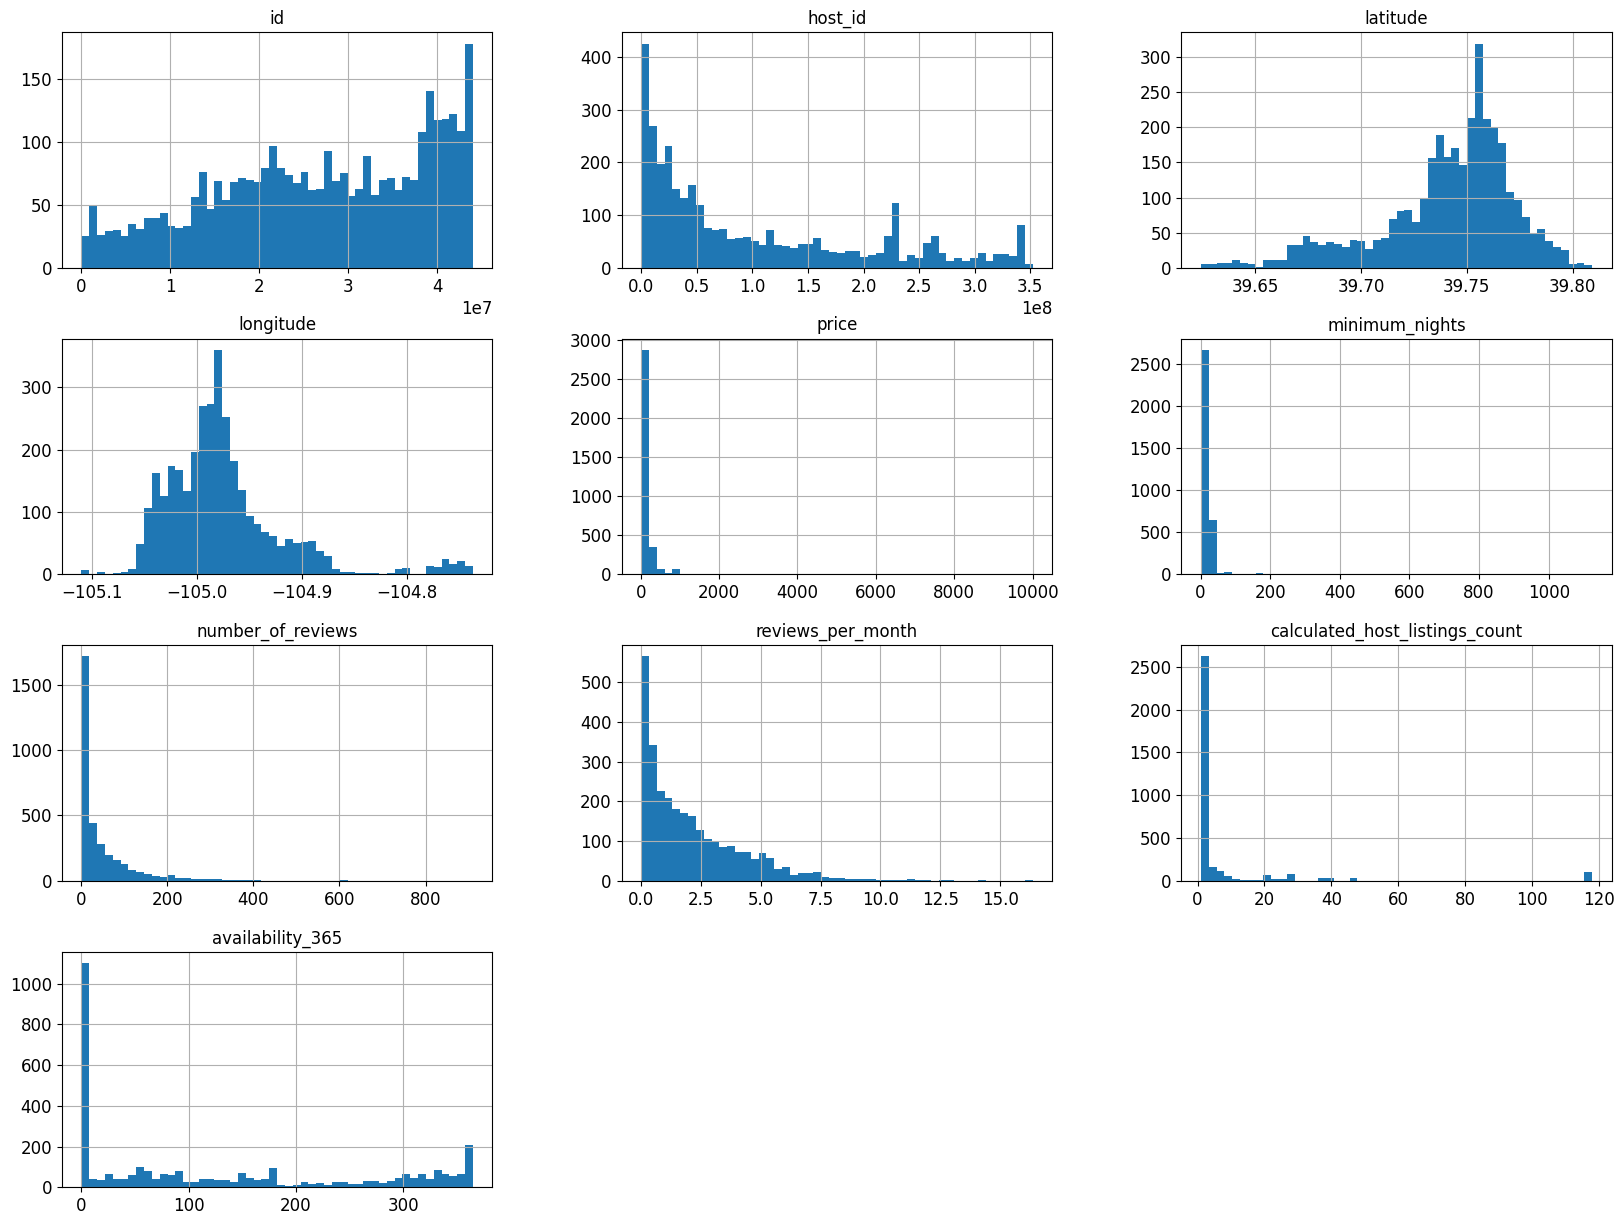

In [ ]:
X.hist(bins=50, figsize=(20,15))
plt.show()

Disso temos que realmente a feature city pode influenciar na feature preço, pois a média dos preços em Denver é aproximadaemnte 50 dolares mais barata quando comparada com a média de todas as cidades juntas.

Agora com a interpretação inicial feita, podemos fazer a matriz de correlação e ver se há uma boa correlação entre as features

In [ ]:
Airbnb_copy = Airbnb_data.copy()
Airbnb_num = Airbnb_copy[['host_id', 'id', 'price', 'minimum_nights', 'latitude', 'longitude', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365' ]]
corr_matrix = Airbnb_num.corr()
corr_matrix

,host_id,id,price,minimum_nights,latitude,longitude,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
host_id,1.000000,0.537608,0.019120,-0.002240,-0.049689,0.009396,-0.188770,0.079857,0.104041,0.085407
id,0.537608,1.000000,0.021852,-0.001807,-0.058692,-0.010939,-0.381600,0.071759,0.161579,0.051774
price,0.019120,0.021852,1.000000,-0.000634,-0.054460,-0.058104,-0.072903,-0.055941,0.042272,0.034791
minimum_nights,-0.002240,-0.001807,-0.000634,1.000000,0.000724,-0.001722,-0.000986,-0.001995,-0.000713,-0.002662
latitude,-0.049689,-0.058692,-0.054460,0.000724,1.000000,0.579660,0.047335,0.052804,-0.183669,-0.177515
longitude,0.009396,-0.010939,-0.058104,-0.001722,0.579660,1.000000,-0.034500,-0.022126,-0.168420,-0.146315
number_of_reviews,-0.188770,-0.381600,-0.072903,-0.000986,0.047335,-0.034500,1.000000,0.731456,-0.119181,0.052273
reviews_per_month,0.079857,0.071759,-0.055941,-0.001995,0.052804,-0.022126,0.731456,1.000000,-0.113764,0.043501
calculated_host_listings_count,0.104041,0.161579,0.042272,-0.000713,-0.183669,-0.168420,-0.119181,-0.113764,1.000000,0.164473
availability_365,0.085407,0.051774,0.034791,-0.002662,-0.177515,-0.146315,0.052273,0.043501,0.164473,1.000000


Da matriz de correlação vemos que as features não possuem uma correlaçao muito alta enem muito baixa o que pode dificultar nossas previsões no futuro.

# Preparando os dados para os modelos

Agora iremos fazer o processamento dos dados no conjunto de treinamento. Para isso criaremos uma cópia dos dados, e separar a feature que queremos prever para mais tarde fazer a validação

In [ ]:
Airbnb_new = Airbnb_train_data.drop(["price", "neighbourhood_group", "name", "last_review", "host_name"], axis=1)
Airbnb_price_labels = Airbnb_data["price"].copy()
Airbnb_new_num = Airbnb_new[['host_id', 'id', 'minimum_nights', 'latitude', 'longitude', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365' ]]

Retiraramos algumas features que julgamos que não irá influenciar no preço de Airbnb que são: "name", "host_name", "neighbourhood_group" e "last_review".

Para reescalar as variaveis, substiuir dados faltantes e tranformar o dtype das features para numérica, iremos precisar das seguintes bibliotecas

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler  #StandardScaler serve para fazer a reescalar das variáveis

try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
    print("Scikit-Learn 0.20+")
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer
    print("Scikit-Learn antes do 0.20")

try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

try:
    from sklearn.preprocessing import OrdinalEncoder # gera um ImportError se Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20


Scikit-Learn 0.20+


Com isso podemos criar um pipeline para preenchimento de dados faltantes seguinte forma

In [ ]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

#Airbnb_num_tr = num_pipeline.fit_transform(Airbnb_new_num)
#Airbnb_num_tr.shape

Além disso podemos criar um novo pipeline em que além disso também irá deixar todas variaveis numéricas utilizando o comando OneHotEncoder()

In [ ]:
num_attribs = list(Airbnb_new_num)
cat_attribs = ["room_type", "city"]

#Este é o pipeline completo!
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs), #um pipeline dentro do outro
        ("cat", OneHotEncoder(), cat_attribs),
    ])

#Airbnb_prepared = full_pipeline.fit_transform(Airbn_data)

Agora podemos separar nosso conjunto de treino para fazer a validação, e nesse conjunto separado fazer a preparação para os dados do modelo

In [ ]:
Airbnb_data_treino, Airbnb_data_teste, Airbnb_label_train, Airbnb_labels_test  = train_test_split(Airbnb_new, Airbnb_price_labels,
                                       test_size=0.2, #20% para teste
                                       random_state=seed)

Vamos ver o tamanho dos dados transformados

In [ ]:
Airbnb_prepared = full_pipeline.fit_transform(Airbnb_data_treino)
Airbnb_test_prepared = full_pipeline.transform(Airbnb_data_teste)
Airbnb_prepared.shape

(144659, 41)

Observe que agora o número de colunas é 41, o que faz sentido pelo uso do OneHotEnconder()

# Treinando e selecionando um Modelo

Agora com nossos dados prontos para os modelos, podemos testar diferentes métodos e compara-los. Aqui daremos os conjuntos Airbnb_data_treino e Airbnb_label_train para o treinamento dos modelos.

Primeiro testando o método de **Regressão Linear**

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(Airbnb_prepared, Airbnb_label_train)

LinearRegression()

Vamos ver como o modelo performa para prever 5 preços de Airbnb do conjunto de teste

In [ ]:
some_data = Airbnb_data_teste.iloc[:5]
some_labels = Airbnb_labels_test.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data) #Full pipeline

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [288.71318425 281.03773637 277.62979305 332.00054463  77.7321653 ]


In [ ]:
print("Labels:", list(some_labels))

Labels: [181, 128, 379, 900, 59]


É possível notar uma dificuldade do método de prever os preços, principalmente do preço que era 900. Agora vamos ver o erro MSE para o conjunto de teste

In [ ]:
Airbnb_predictions = lin_reg.predict(Airbnb_test_prepared)
lin_mse = MSE(Airbnb_labels_test, Airbnb_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse #

517.0619839202463

517!! Um erro bem alto. Provavelmente o método de regressão linear não é um bom generalizador para o problema.

Agora vamos testar o método **Árvore de Decisão**

In [ ]:
tree_reg = DecisionTreeRegressor(random_state= seed)
tree_reg.fit(Airbnb_prepared, Airbnb_label_train)

DecisionTreeRegressor(random_state=42)

Vamos ver como esse método prever os mesmos 5 preços de Airbnb

In [ ]:
some_data = Airbnb_data_teste.iloc[:5]
some_labels = Airbnb_labels_test.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data) #Full pipeline

print("Predictions:", tree_reg.predict(some_data_prepared))

Predictions: [ 355.  450.  229. 2895.   55.]


In [ ]:
print("Labels:", list(some_labels))

Labels: [181, 128, 379, 900, 59]


Das previsões vemos também uma discrepância com os preços originais, e no airbnb com diária 900 ele acabou prevendo um preço muito maior.

In [ ]:
Airbnb_predictions = tree_reg.predict(Airbnb_test_prepared)
tree_mse = MSE(Airbnb_labels_test, Airbnb_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

593.4100553972258

593 !! Um erro maior que o da regressão linear. Será que não estamos tratando os dados da forma correta? Ou pelo fato das variaveis ter pouca correlação está dificultando os métodos de fazerem previsões?

Vamos agora testar o método **Foresta Aleatória**

In [ ]:
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(Airbnb_prepared, Airbnb_label_train) #Treinar modelo

RandomForestRegressor(n_estimators=10, random_state=42)

Testando ele também para prever os 5 preços, temos

In [ ]:
some_data = Airbnb_data_teste.iloc[:5]
some_labels = Airbnb_labels_test.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data) #Full pipeline

print("Predictions:", forest_reg.predict(some_data_prepared))

Predictions: [ 212.8  151.7  238.  1267.5   53.2]


In [ ]:
print("Labels:", list(some_labels))

Labels: [181, 128, 379, 900, 59]


É possível notar uma melhor previsão em quase todos os preços quando comparado com os outros. Vejamos o erro MSE

In [ ]:
Airbnb_predictions = forest_reg.predict(Airbnb_test_prepared) #Predizer
forest_mse = MSE(Airbnb_labels_test, Airbnb_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

430.6263830429831

Notamos um erro também bem alto. Apesar deste erro alto, é o modelo que melhor performou, então iremos utilizar um RandomizedSearchCV para encontrar os melhores parâmetros para este modelo  

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=6, high=41),
    }

forest_reg = RandomForestRegressor(random_state=seed)

rnd_search = RandomizedSearchCV(forest_reg,
                                param_distributions=param_distribs,
                                n_iter=7,
                                cv=3,
                                scoring='neg_mean_squared_error',
                                random_state=seed,
                                n_jobs=-1
                                 )

rnd_search.fit(Airbnb_prepared, Airbnb_label_train)

Com isso podemos finalmente ver como o modelo prevê o dados no conjunto de teste

# Teste final

Finalmente podemos utilizar o nosso conjunto de teste para ver o quão bom é a generalização do método escolhido

In [ ]:
best_forest_reg = rnd_search.best_estimator_

X_test = test_set.drop("price", axis=1)
y_test = test_set["price"].copy()

X_test_prepared = full_pipeline.transform(X_test)
price_predictions = best_forest_reg.predict(X_test_prepared)

final_mse = MSE(y_test, price_predictions)
final_rmse = np.sqrt(final_mse)


In [ ]:
final_rmse

448.194285390221

Ainda assim obtemos um erro alto, ou seja, os modelos tem uma deficuldade em generalisar este tipo de problema.